In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
# import the state/action space generating function
from state_space_setup import *


# load the necessary data created by the optimisation script
cost_matrix = np.load("cost_matrix.npy")
trans_prob_matrix = np.load('trans_prob_matrix.npy')
policy = pd.read_csv('policy.csv')

# format the State column in the policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))

# display the policy to dataframe to verify that the loading was successful
display(policy)

# extract the maximum number of parts from the policy dataframe
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

,State,Order_size
0,"(0, 0)",21
1,"(0, 1)",20
2,"(0, 2)",19
3,"(0, 3)",18
4,"(0, 4)",17
...,...,...
248,"(19, 1)",0
249,"(19, 2)",0
250,"(20, 0)",0
251,"(20, 1)",0


Maximum number of parts in the inventory: 21


In [3]:
# simulation function
def simulate_period(initial_state, policy_df, num_periods = 510):
    """
    Input: initial_state (tuple): Initial state of the inventory.
           policy_df (pd.DataFrame): A two-column dataframe representing the chosen policy.
           num_periods (int): The number of weeks for which we want the simulation to run.
    Output: SAC_df (pd.DataFrame): Dataframe containing the states, chosen actions and the
                                   costs associated with (old state, action, new state).

    This function simulates num_periods weeks of inventory states. At each stage the 
    algorithm picks an action according to the provided policy (policy_df), draws a 
    new state according to the probability transition matrix and computes the associated
    cost using the cost matrix - both created in the optimisation script.
    """
    global maximum_parts
    global trans_prob_matrix
    global cost_matrix

    # intialise the list to store the states, actions and costs
    states = [initial_state]
    actions = [policy_df.loc[policy_df["State"] == initial_state, "Order_size"].values[0]]
    costs = [0]

    for _ in range(num_periods):
        # get the current state action
        current_state = states[-1]
        action = actions[-1]

        # sample the new state based on the current state and action
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        pmf = trans_prob_matrix[current_idx, :, action]
        new_state = state_tuples[np.random.choice(np.arange(len(state_tuples)), p=pmf)]
        
        # calculate and store the cost of the simulated scenario
        new_idx = get_index(new_state[0], new_state[1], maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs.append(cost)

        # store the new state and the corresponding action
        states.append(new_state)
        actions.append(policy_df.loc[policy_df["State"] == new_state, "Order_size"].values[0])

    SAC_df = pd.DataFrame({
        "States" : states,
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df

In [4]:
def total_cost(simulated_data, plots = True, discount_factor=0.995):
    """
    Input: simulated_data (pd.DataFrame): A three-column dataframe containing the simulated
                                          states, chosen actions and associated costs.
           plots (bool): Variable indicating if plots should be produced
           discount_factor (float): Chosen discount factor weighting the future costs.
    Output: total_cost (float): Total discounted cost of the initial state over the 
                                simulated period.

    This function takes the simulated output in the form of a dataframe. If the plots parameter
    is set to True, the function presents the trend in the inventory level and position as 
    line plots as well as cumulative discounted cost of the initial state along with the 
    cumulative number of ordered parts.
    """
    
    # calculate the discounted cumulative cost
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    cum_discounted_cost = np.cumsum(factor_sequence * np.array(simulated_data["Costs"]))

    if plots:
        # not so disgusting colours for the plots
        col1 = '#1F77B4'
        col2 = '#2CA02C'
        col3 = '#D62728'
        col4 = "#DACE4A"
        
        # prepare the data for plotting
        inventory_levels = [state[0] for state in simulated_data["States"]]
        inventory_positions = [state[0] + state[1] for state in simulated_data["States"]]
        cum_orders = np.cumsum(simulated_data["Actions"])

        # plot the inventory levels, positions and the cumulative costs
        fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

        # subplot 1: inventory level
        axs[0].plot(np.arange(len(inventory_levels)), inventory_levels, 
                    label='Inventory Level', color=col1, linewidth=0.75)
        axs[0].set_ylabel('Inventory Level')
        axs[0].legend()

        # subplot 2: inventory position
        axs[1].plot(np.arange(len(inventory_positions)), inventory_positions, 
                    label='Inventory Position', color=col2, linewidth=0.75)
        axs[1].set_ylabel('Inventory Position')
        axs[1].legend()

        # subplot 3: cumulative cost
        axs[2].plot(np.arange(len(cum_discounted_cost)), cum_discounted_cost, 
                    label='Cumulative Discounted Value of the Initial State', color=col3,
                    linewidth=0.75)
        axs[2].set_ylabel('Cumulative Cost')
        axs[2].set_xlabel('Week')
        axs[2].legend()

        # subplot 4: cumulative number of ordered parts
        axs[3].plot(np.arange(len(cum_orders)), cum_orders, 
                    label='Cumulative Number of Ordered Parts', color=col4,
                    linewidth=0.75)
        axs[3].set_ylabel('Ordered Parts')
        axs[3].set_xlabel('Week')
        axs[3].legend()

        plt.tight_layout()
        plt.show()
        
    # extract the estimated total discounted cost of the initial state
    total_cost = cum_discounted_cost[-1]
    return total_cost

Initial state: (5, 2)


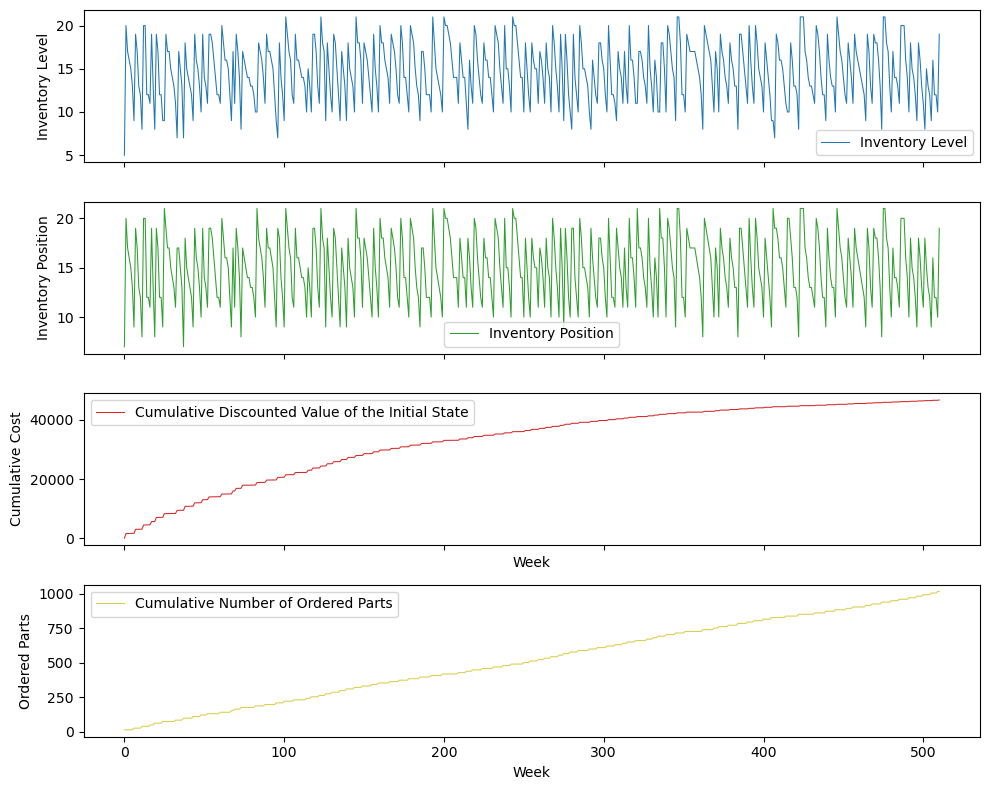

46753.50302636751


In [5]:
# set the seed for reproducibility
np.random.seed(42)

# choose a random initial state from the state space
sampled_state = state_tuples[np.random.randint(len(state_tuples))]
print("Initial state:", sampled_state)

# simulate the period
data = simulate_period(sampled_state, policy)
print(total_cost(data))

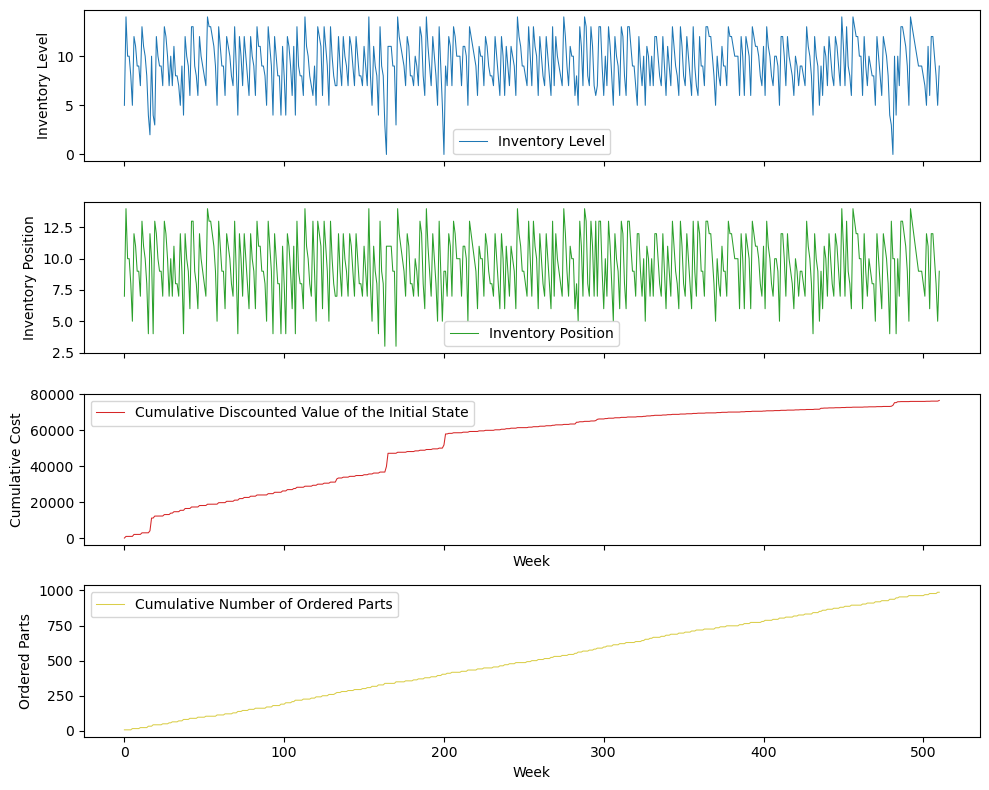

76551.52430458934


In [6]:
from policy_df_genetor import *

policy2 = generate_sS_policy(7, 14, maximum_parts)
data2 = simulate_period(sampled_state, policy2)
print(total_cost(data2))